In [29]:
# %matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

## Funciones generales

In [30]:
#Da el espectro identificando los primeros máximos sin analizar
def Spectrum(datax,datay,intensity,num):
    marker_x = []
    marker_y = []
    index_y = []
    index_x = []
    anotaciones = []

    for i in range(0,len(datax)):
        mark = i

        if mark != 0 and mark != len(datax)-1:
            last = datay[mark - 1]
            next = datay[mark + 1]

            #Hallar máximos de espectro
            if (last < datay[i]) and (next < datay[i]) and (datay[i]>intensity):
                marker_x.append(datax[i])
                marker_y.append(datay[i])

                index_y.append( datay[i-num:i+num] )
                index_x.append( datax[i-num:i+num] )

                anotaciones.append(str(datax[i]))
                
    return marker_x,marker_y,index_x,index_y,anotaciones


#Procesa el archivo txt de datos, inten se refiere a la intensidad mínima para buscar y num a la cantidad de puntos alrededor de la lorentziana
def DataProcess(l,inten,num):
    data = pd.read_csv(l, delimiter=' ')
    pixel = np.array(data['P'])
    intensidad = np.array(data['I'])

    marker_x,marker_y, index_x,index_y,anotaciones = Spectrum(pixel,intensidad,inten,num)
    
    return pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones


#Retira aquellas líneas que no aparecen en el catálogo o no ayudan a la obtención de la lorentziana
def DataCatalogue(pixs,marker_x,marker_y, index_x,index_y,anotaciones):
    mar_x = []
    mar_y = []
    ind_y = []
    ind_x = []
    anot = []
   

    for i in range(0,len(marker_x)):
        if marker_x[i] not in pixs:
            mar_x.append(marker_x[i])
            mar_y.append(marker_y[i])
            ind_x.append(index_x[i])
            ind_y.append(index_y[i])
            anot.append(anotaciones[i])

    return mar_x,mar_y, ind_x,ind_y,anot


#Función Lorentziana
def Lorentzian(x,h,x0,W):
    return h*W**2/((x-x0)**2+W**2)


#Realiza el ajuste Lorentziano sobre el espectro catalogado
def AjusteLorentz(i,index_x, index_y):
    x = index_x[i]
    y = index_y[i] 
    x_1 = np.linspace(x[0],x[-1],500 )

    popt, _ = curve_fit(Lorentzian,x,y) 
    h = popt[0]
    x0 = popt[1]
    w = popt[2]

    fit_y= Lorentzian(x_1,h,x0,w)

    return x0,h,fit_y,x_1, x, y


#Devuelve el DataFrame con los píxeles calculados
def MakeDataFrame(rango,catalog_long,index_x, index_y):

    Datafit = pd.DataFrame()
    lineasfit = []
    alturafit = []

    for i in range(0,rango):
        linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x, index_y)
        lineasfit.append(linea)
        alturafit.append(altura)
    

    Datafit['Pixel'] = lineasfit
    Datafit['Intensidad'] = alturafit
    Datafit['Catalogo longitud'] = catalog_long

    return Datafit

#Obtener la regresion lineal
def LinearFit(datax,datay,n):
    param = np.polyfit(datax,datay, n)
    xm = np.linspace(min(datax),max(datax),len(datax))
    ym = np.polyval(param, xm)
    xres = datax
    ye = np.polyval(param, datax)
    res = ye - datay

    return ym,xm,res,xres,param

#Obtener la calibración de las lineas sospechosas
def LineasSus(pixs,param):
    Data = pd.DataFrame()
    Data['Pixel'] = pixs
    Orden1 = []
    Orden2 = []
    Orden3 = []
    for i in pixs:
        Orden1.append(np.polyval(param,i)*2)
        Orden2.append(np.polyval(param,i)) 
        Orden3.append(np.polyval(param,i)*(2/3)) 
    
    Data['Calibracion orden 1'] = Orden1
    Data['Calibracion orden 2'] = Orden2
    Data['Calibracion orden 3'] = Orden3

    return Data

#Convertir DataFrame a tabla de Latex
# print(DataFit_1.to_latex(index=False))

## Análisis

### Para intensidades grandes >575

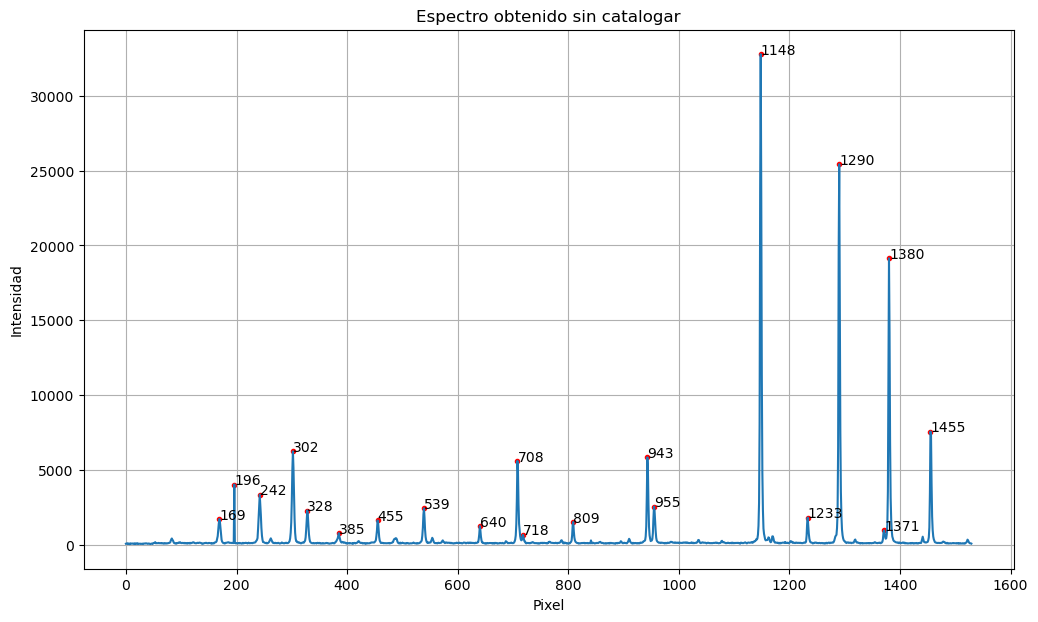

In [ ]:
pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt", 575, 7)

#Grafica
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x,marker_y,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))
#fig1.savefig('th 6200 orden 2 espectro tratado.jpg')

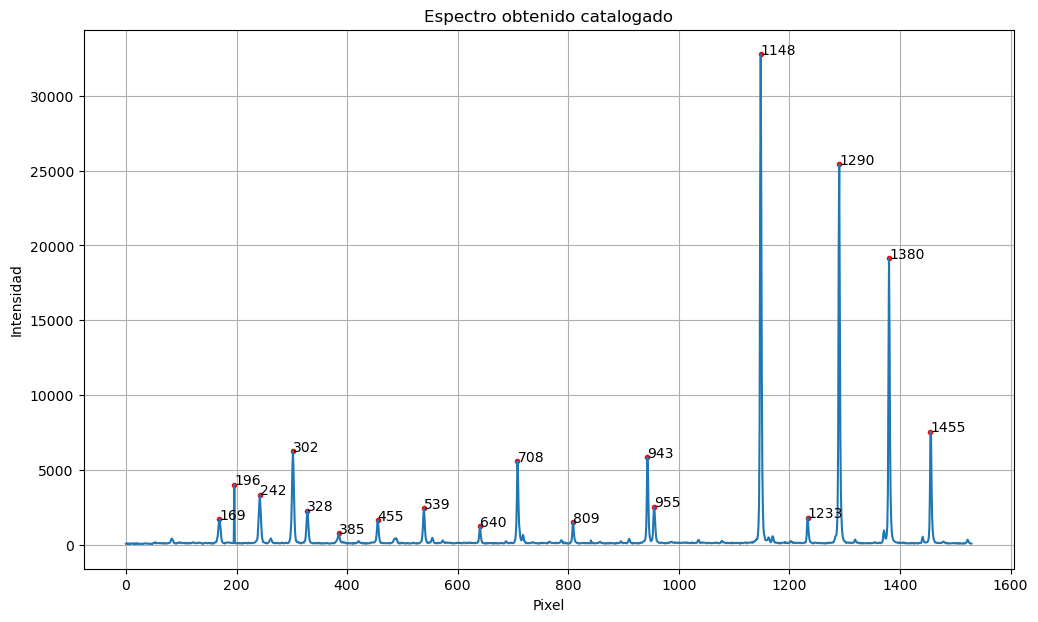

In [32]:
#Lista de pixeles que podrian ser de ordenes diferentes
PixSus_1 = [718, 1371]

#Se obtiene el espectro limpio
marker_x,marker_y, index_x,index_y,anotaciones = DataCatalogue(PixSus_1,marker_x,marker_y, index_x,index_y,anotaciones)
    
#Grafica
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_x,marker_y,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))
#fig2.savefig('th 6200 orden 2 espectro tratado.jpg')

## Análisis adicional para catalogar líneas 

In [33]:
pixnon = [169,196,242,302,328,385,455,539,640,708,809, 1233]
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixnon,marker_x,marker_y, index_x,index_y,anotaciones)

# #Grafica
# fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
# ax1.plot(pixel,intensidad)
# ax1.scatter(marker_x_,marker_y_,marker='.',color = 'red')
# ax1.set_title('Espectro obtenido sin catalogar')
# ax1.set_xlabel('Pixel')
# ax1.set_ylabel('Intensidad')
# ax1.grid()
# for i, label in enumerate(anotaciones_):
#     plt.annotate(label, (marker_x_[i] + 0.1, marker_y_[i]))


In [34]:
catalog_long = [6577.213, 6577.656, 6583.906, 6588.539, 6591.484, 6593.939]
DataFit = MakeDataFrame(len(marker_x_),catalog_long,index_x_, index_y_)

ym,_x,res,xres,param = LinearFit(DataFit['Pixel'],DataFit['Catalogo longitud'], 2) 

# #Gráfico con residuos
# fig1, axis1 = plt.subplots(2,1, figsize = (9, 7), gridspec_kw = {"height_ratios":[2, 1]})
# ax1 = axis1[0]
# ax2 = axis1[1]

# fig1.suptitle(r'Relación entre pixel y longitud de onda calibrados',fontsize=14)

# ax1.scatter(DataFit['Pixel'],DataFit['Catalogo longitud'])
# ax1.plot(_x,ym,'--',color='purple')
# ax1.set_ylabel(r"$\lambda$",fontsize=14)
# ax1.set_xlabel(r'pixel',fontsize=14)
# ax1.grid()
# ax1.tick_params(axis='both',labelsize=13)

# ax2.scatter(xres,res,label = 'Residuos',color='purple')
# ax2.grid()
# ax2.tick_params(axis='both',labelsize=13)
# ax2.legend()
# ax1.set_xlabel(r'pixel',fontsize=14)

# fig1.tight_layout()
# #fig1.savefig('DvsV.jpg')
print(param)

[2.17162659e-08 3.25602598e-02 6.54650132e+03]


In [35]:
def Cal(pixel,param):
    list = []
    for each in pixel:
        list.append(param[0]*each**2 + param[1]*each + param[2])
    return list 

l = [169,196,242,302,328]

Cal(l,param)

[6552.0046222286865,
 6552.883963256063,
 6554.382172744445,
 6556.336497149088,
 6557.183419615338]

## De vuelta al análisis en general

In [36]:
#Longitudes de onda sospechosas de ser de diferente orden únicamente
PixSus_1 = [169,196,302,328,385,455,539,640,809, 1233]
marker_x,marker_y, index_x,index_y,anotaciones = DataCatalogue(PixSus_1,marker_x,marker_y, index_x,index_y,anotaciones)

#Longitudes de onda observadas en el catalogo, ingreso manual
catalog_long = [6554.160, 6569.632, 6577.213, 6577.656, 6583.906, 6588.539, 6591.484, 6593.939]
DataFit_1 = MakeDataFrame(len(marker_x),catalog_long,index_x, index_y)
DataFit_1

,Pixel,Intensidad,Catalogo longitud
0,242.064134,3384.426104,6554.160
1,708.405532,6000.588168,6569.632
2,943.369154,6327.962921,6577.213
3,955.400428,2676.776012,6577.656
4,1148.053822,34273.594017,6583.906
5,1289.908924,26686.591664,6588.539
6,1380.209971,20088.799058,6591.484
7,1455.537650,8741.711485,6593.939


### Para líneas con intensidades pequeñas < 525

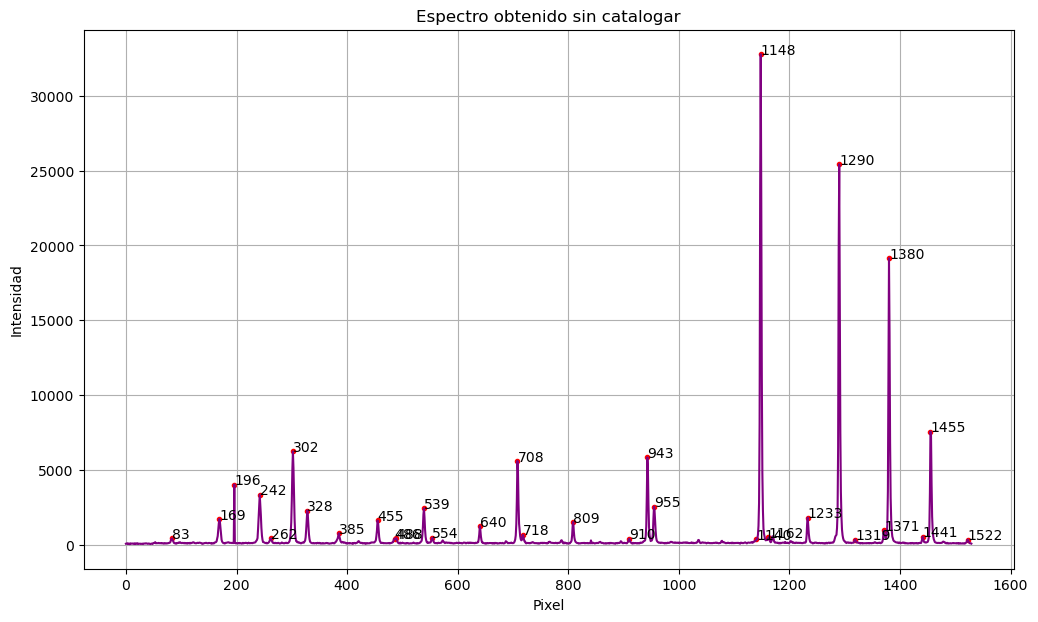

In [76]:
pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt",355,18)

#Grafica
fig1_, ax1_ = plt.subplots(1,1, figsize=(12,7))
ax1_.plot(pixel_,intensidad_, color='purple')
ax1_.scatter(marker_x_,marker_y_,marker='.',color = 'red')
ax1_.set_title('Espectro obtenido sin catalogar')
ax1_.set_xlabel('Pixel')
ax1_.set_ylabel('Intensidad')
ax1_.grid()
for i, label in enumerate(anotaciones_):
    plt.annotate(label, (marker_x_[i] + 0.1, marker_y_[i]))
#fig1_.savefig('th 6200 orden 2 espectro tratado.jpg')

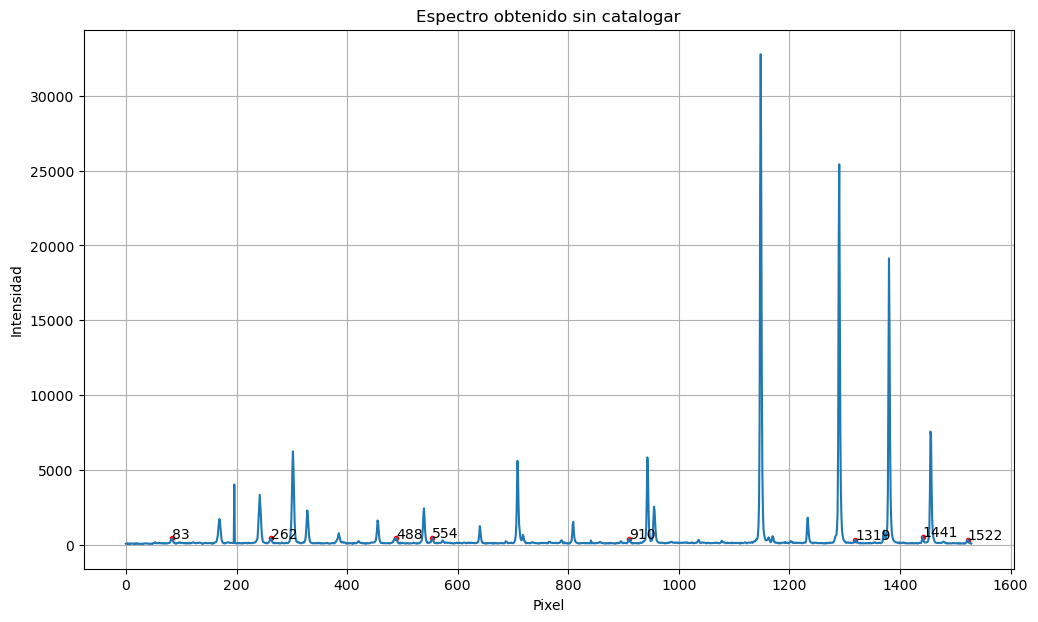

In [38]:
pixnon = [486, 718, 1140,1162,1371 ,169,196,302,328,385,455,539,640,809, 1233, 1148, 1290, 1380,1455, 943, 955, 708,242] #Lineas que no aportan al análisis o ya se analizaron
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixnon,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

#Grafica
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x_,marker_y_,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones_):
    plt.annotate(label, (marker_x_[i] + 0.1, marker_y_[i]))

In [39]:
#Longitudes de onda sospechosas de ser de diferente orden únicamente
PixSus_2 = [1319, 554, 262, 488, 83] 
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(PixSus_2,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

analisis = [1522, 1441, 910]
catalog_long_2 = [6596.100, 6593.461, 6576.122]

#### Lineas para analizar individualmente

In [40]:
#NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
pixsus = [1319, 554, 262, 488, 83, 486, 718, 1140,1162,1371 ,169,196,302,328,385,455,539,640,809, 1233, 1148, 1290, 1380,1455, 943, 955, 708,242, 1441, 910] 

pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt",355,5)
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

catalog_long_2 = [6596.100]
DataFit_21 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

DataFit_21

,Pixel,Intensidad,Catalogo longitud
0,1522.316969,331.237776,6596.1


In [41]:
#NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
pixsus = [1319, 554, 262, 488, 83, 486, 718, 1140,1162,1371 ,169,196,302,328,385,455,539,640,809, 1233, 1148, 1290, 1380,1455, 943, 955, 708,242, 1522, 910] 

pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt",355,11)
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

catalog_long_2 = [6593.461]
DataFit_22 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

DataFit_22

,Pixel,Intensidad,Catalogo longitud
0,1441.633172,352.796755,6593.461


In [42]:
#NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
pixsus = [1319, 554, 262, 488, 83, 486, 718, 1140,1162,1371 ,169,196,302,328,385,455,539,640,809, 1233, 1148, 1290, 1380,1455, 943, 955, 708,242, 1441, 1522] 

pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt",355,8)
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

catalog_long_2 = [6576.122]
DataFit_23 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

DataFit_23

,Pixel,Intensidad,Catalogo longitud
0,910.076805,357.999332,6576.122


#### Lineas especiales

In [43]:
# # Solo descomentar si es necesario un análisis con gráfica para ver el ajuste
# pixsus = [] #lineas ya analizadas

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt",275,18)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)


# def MakeDataFrame(rango,catalog_long,index_x_,index_y_):

#     Datafit = pd.DataFrame()
#     lineasfit = []
#     alturafit = []

#     for i in range(0,rango):
#         linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x_,index_y_)
#         lineasfit.append(linea)
#         alturafit.append(altura)
    

#     Datafit['Pixel'] = lineasfit
#     Datafit['Intensidad'] = alturafit
#     Datafit['Catalogo longitud'] = catalog_long

#     return Datafit, fity, fitx, x, y

# catalog_long_2 = []
# DataFit_2, fity, fitx, x, y = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(x,y)

### Unir todo en un dataframe

In [44]:
DataFit = pd.concat([DataFit_1,DataFit_21,DataFit_22, DataFit_23], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)
DataFit

,Pixel,Intensidad,Catalogo longitud
0,242.064134,3384.426104,6554.160
1,708.405532,6000.588168,6569.632
2,910.076805,357.999332,6576.122
3,943.369154,6327.962921,6577.213
4,955.400428,2676.776012,6577.656
5,1148.053822,34273.594017,6583.906
6,1289.908924,26686.591664,6588.539
7,1380.209971,20088.799058,6591.484
8,1441.633172,352.796755,6593.461
9,1455.537650,8741.711485,6593.939


### Regresión lineal de todos los puntos

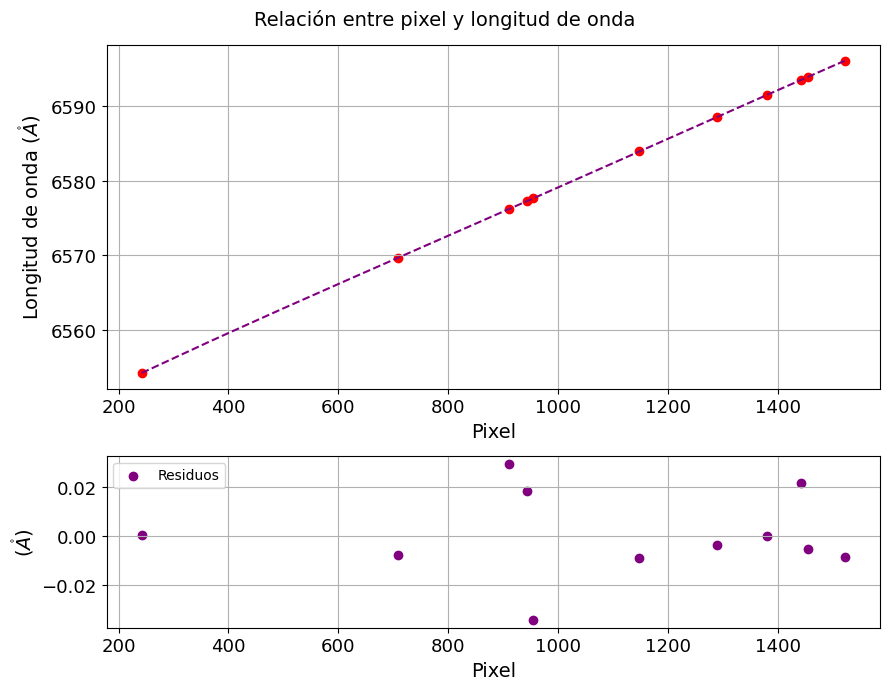

In [78]:
ym,_x,res,xres,param = LinearFit(DataFit['Pixel'],DataFit['Catalogo longitud'], 4) 

#Gráfico con residuos
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Relación entre pixel y longitud de onda',fontsize=14)

ax1.scatter(DataFit['Pixel'],DataFit['Catalogo longitud'], color = 'red')
ax1.plot(_x,ym,'--',color='purple')
ax1.set_ylabel(r"Longitud de onda ($\mathring{A}$)",fontsize=14)
ax1.set_xlabel(r'Pixel',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(xres,res,label = 'Residuos',color='purple')
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)
ax2.legend()
ax2.set_xlabel(r'Pixel',fontsize=14)
ax2.set_ylabel(r'($\mathring{A}$)', fontsize=14)

fig1.tight_layout()
#fig1.savefig('DvsV.jpg')

### Análisis líneas sospechosas

In [72]:
# Por si se necesita quitar algun elemento None del dataframe .drop([2],axis=0).reset_index(drop=True)
LineasSos_1 = LineasSus(PixSus_1,param)
LineasSos_1['Catalogo longitud'] = [4367.8314, 4368.3544 , 4370.7529 ,4371.3576, 4372.6493, 4374.12377 , 4376.2588, 4378.3631, 4381.86008, 4391.11045]
LineasSos_1['Elemento'] = ['Ar II', 'Th I', 'Ar II' , 'Th I', 'Th I', 'Th I' ,'Th I', 'Th I', 'Th II', 'Th II']


LineasSos_2 = LineasSus(PixSus_2,param)
LineasSos_2['Catalogo longitud'] = [4392.97395, 4376.4297, None, None, 4365.642]
LineasSos_2['Elemento'] = ['Th I', 'Th II', None, None, 'Fe III' ]

LineasSos = pd.concat([LineasSos_1,LineasSos_2], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True).drop([3],axis=0).reset_index(drop=True).drop([7],axis=0).reset_index(drop=True)
LineasSos['Longitud Calculada'] = LineasSos['Calibracion orden 3']
LineasSos = LineasSos.drop(['Calibracion orden 1', 'Calibracion orden 2', 'Calibracion orden 3'], axis=1)
LineasSos


,Pixel,Catalogo longitud,Elemento,Longitud Calculada
0,83,4365.64200,Fe III,4365.647897
1,169,4367.83140,Ar II,4367.726743
2,196,4368.35440,Th I,4368.365052
3,302,4370.75290,Ar II,4370.816314
4,328,4371.35760,Th I,4371.406157
5,385,4372.64930,Th I,4372.686438
6,455,4374.12377,Th I,4374.238599
7,539,4376.25880,Th I,4376.079210
8,554,4376.42970,Th II,4376.405973
9,640,4378.36310,Th I,4378.271592


### Revisar residuos de lineas sospechosas

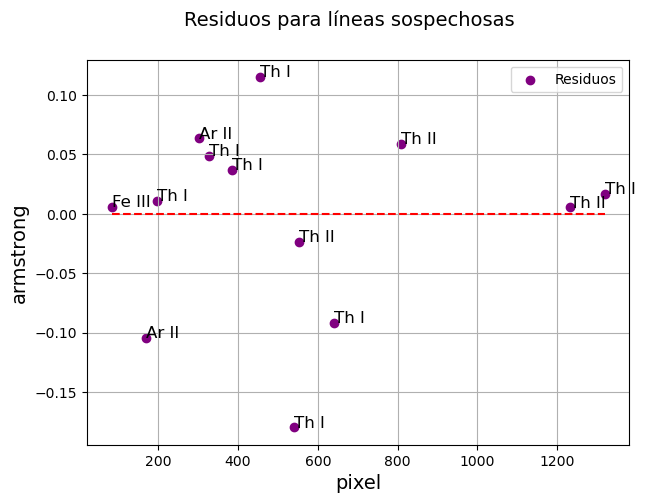

In [ ]:
#Calcular residuos de las líneas sospechosas
nist = LineasSos['Catalogo longitud']
calc = LineasSos['Longitud Calculada']
residuos = calc - nist

pixel = LineasSos['Pixel']

#Etiquetas de elementos
label = [each for each in LineasSos['Elemento']]

#Gráfico con residuos
fig, ax = plt.subplots(1,1, figsize=(7,5))

fig.suptitle(r'Residuos para líneas sospechosas',fontsize=14)

ax.scatter(pixel,residuos,label = 'Residuos',color='purple')
ax.plot(pixel,np.linspace(0,0,len(residuos)),'--',color='red')
ax.grid()
ax.legend()
ax.set_xlabel(r'Pixel',fontsize=14)
ax.set_ylabel(r'Armstrong',fontsize=14)

for j in range (0, len(label)):
    plt.annotate(label[j], (pixel[j], residuos[j]),fontsize=12)

#fig1.savefig('DvsV.jpg')